An autoencoder __encodes data in a latent-space__ minimizing the reconstruction error.

<img src="https://miro.medium.com/max/1200/1*ViBG49eTCKqqO2UVRL9mEw.png" width="500px"/>

It is composed by:

- encoder (E): encodes the data in the latent-space (as a *code*);
- decoder (D): reconstructs the data from the latent-space representation.

Depending on the code size:

- __undercomplete__: dimensionality reduction, classical case;
- __overcomplete__: code bigger, without additional constraints the identity funciton is learned.

The objective is generating an output as close as possible to the input.

One immediate choice for the loss is MSE:

$$\Large
\mathcal{L}(\{x,\hat{x}\}) = \sum_i \|x_i-\hat{x}_i\|^2
$$

In case of linear activations:

$$\large
\begin{eqnarray}
z &=& E(x) = W_E x + b_E \\
\hat{x} &=& D(z) = W_D z + b_D \\
        &=& W_D W_E x + W_D b_E + b_D \\
        &=& W_{AE} x + b_{AE} \\
\end{eqnarray}
$$

representing just a linear transformation with bias.

# Deep convolutional autoencoders

Deep is.. deep:

<img src="https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png" width="500px"/>

Every block is convolutional (with activation).

In [1]:
# Just to work comfortably with py files:
%load_ext autoreload
%autoreload 2

## Convolutional autoencoders

Convolution is the base operation both in encoding and decoding.

Let's create one that encodes MNIST digits.

Train samples: 60000
Test samples: 10000


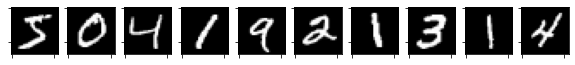

In [2]:
from plotting import plot_images
from dataset import load_mnist, PairDataset

# Mnist dataset:
mnist_train = load_mnist(train=True)
train_ds = PairDataset(mnist_train, mnist_train)
print(f"Train samples: {len(train_ds)}")

mnist_test = load_mnist(train=False)
test_ds = PairDataset(mnist_test, mnist_test)
print(f"Test samples: {len(test_ds)}")

# Showing some digits:
plot_images(mnist_train[0:10,:,:]);

### The convolutional autoencoder

In [3]:
from autoencoders import Encoder, Decoder, Autoencoder
from modules import num_params

enc = Encoder()
t_in = mnist_train[0:4,None,:,:]
t_code = enc(t_in)
print(f"Encoder:\n\tshapes: {tuple(t_in.shape)} => {tuple(t_code.shape)}")
print(f"\tparameters: {num_params(enc)}\n")

dec = Decoder()
t_out = dec(t_code)
print(f"Decoder:\n\tshapes: {tuple(t_code.shape)} => {tuple(t_out.shape)}")
print(f"\tparameters: {num_params(dec)}\n")

ae = Autoencoder()
t_out = ae(t_in)
print(f"Autoencoder:\n\tshapes:{tuple(t_in.shape)} => {tuple(t_out.shape)}")
print(f"\tparameters: {num_params(ae)}")

Encoder:
	shapes: (4, 1, 28, 28) => (4, 32, 1, 1)
	parameters: 26368

Decoder:
	shapes: (4, 32, 1, 1) => (4, 1, 28, 28)
	parameters: 26337

Autoencoder:
	shapes:(4, 1, 28, 28) => (4, 1, 28, 28)
	parameters: 52705


### Training the autoencoder

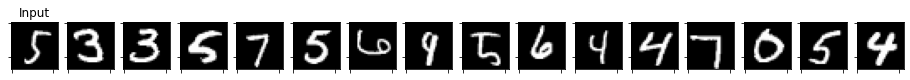

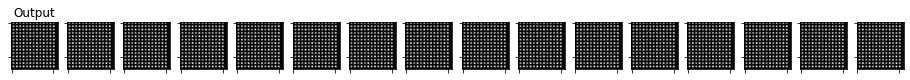

test_loss_before = 0.11343817854193365



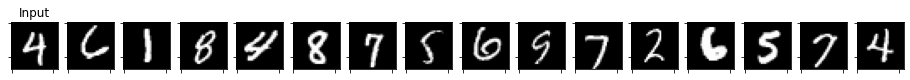

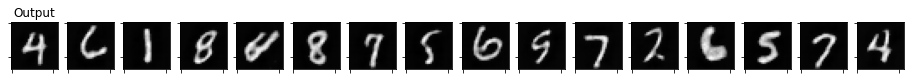

train_loss[0] = 0.015589204155651333
test_loss[0] = 0.008495070710540956



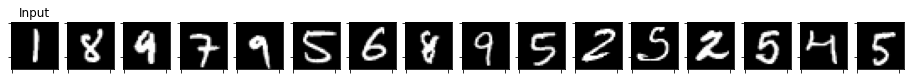

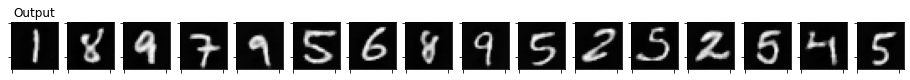

train_loss[1] = 0.008370717534167902
test_loss[1] = 0.007839433715388084



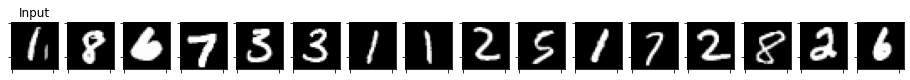

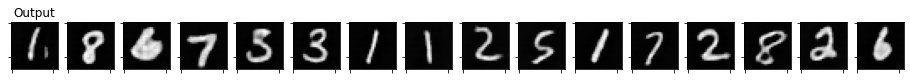

train_loss[2] = 0.007817638347417846
test_loss[2] = 0.007731174136612826



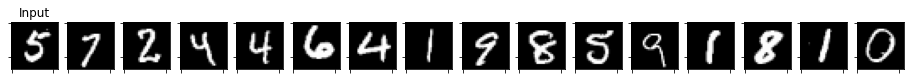

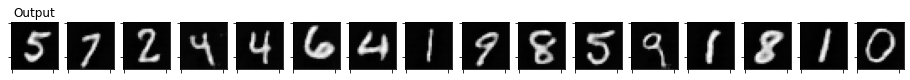

In [4]:
from training import train
from torch.nn import MSELoss

ae, loss_tr, loss_te = train(train_ds, test_ds, Autoencoder(), MSELoss(), epochs=3)

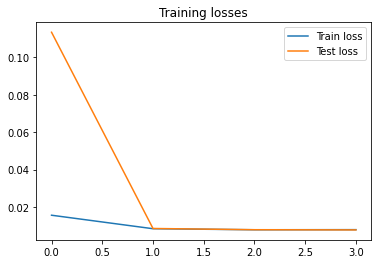

In [5]:
from plotting import plot_losses

plot_losses(loss_tr, loss_te)

## Denoising autoencoders

Denoising autoencoders are autoencoders trained to output cleaned samples given noisy samples in input.

They learn a __noise correction vector space__:

<img src="https://qph.cf2.quoracdn.net/main-qimg-cf9f1903c8a7720722769ad831ee3cf1" width="500"/>

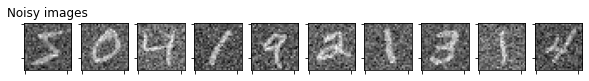

In [6]:
from dataset import corrupt

mnist_train_noisy = corrupt(mnist_train)
dtrain_ds = PairDataset(mnist_train_noisy, mnist_train)

mnist_test_noisy = corrupt(mnist_test)
dtest_ds = PairDataset(mnist_test_noisy, mnist_test)

plot_images(mnist_train_noisy[0:10,:,:], "Noisy images");

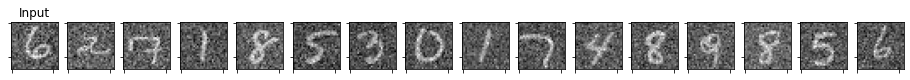

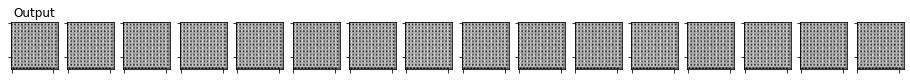

test_loss_before = 0.11410483727409582



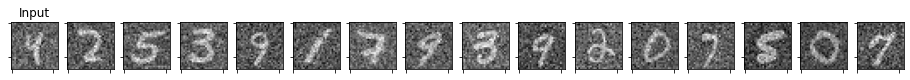

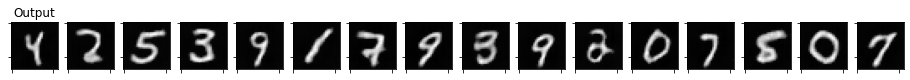

train_loss[0] = 0.01893333296801871
test_loss[0] = 0.01205172176194039



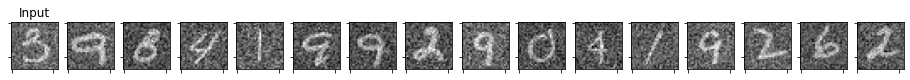

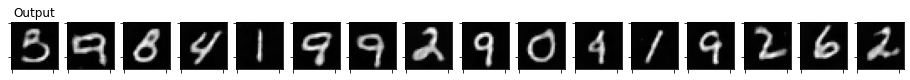

train_loss[1] = 0.011869169945425508
test_loss[1] = 0.011168813712562725



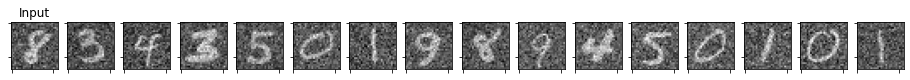

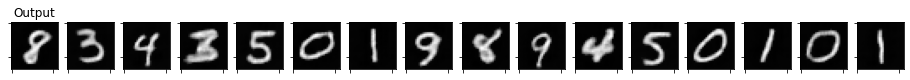

train_loss[2] = 0.011125065671252226
test_loss[2] = 0.01061754627449877



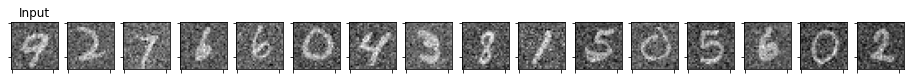

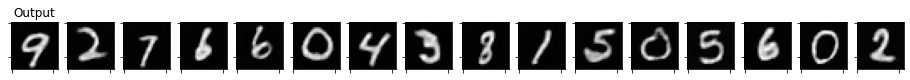

In [7]:
from training import train
from torch.nn import MSELoss

dae, loss_dtr, loss_dte = train(dtrain_ds, dtest_ds, Autoencoder(), MSELoss(), epochs=3)

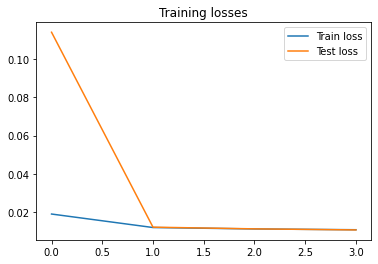

In [8]:
from plotting import plot_losses

plot_losses(loss_dtr, loss_dte)

## Data generation

What if we wish to generate data using the decoder only?

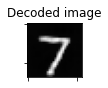

In [9]:
from torch import no_grad

# Splitting the model:
encoder = dae[0]
decoder = dae[1]

def gnerate_and_plot(encoded):
    with no_grad():
        # Decoding it:
        decoded = decoder(encoded)[:,0,:,:]

        # Is this process ok?
        plot_images(decoded, "Decoded image");
    
# Encoding and plotting one image:
encoded = encoder(mnist_test_noisy[0:1,None,:,:])
gnerate_and_plot(encoded)

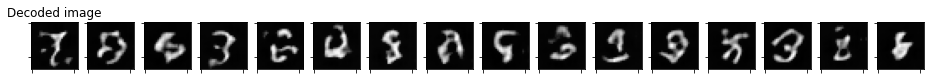

In [11]:
from torch import mean, std, tensor
import numpy as np

with no_grad():
    # Estimating the normal parameters (diagonal covariance):
    encoded_test = encoder(mnist_test_noisy[0:256,None,:,:])
    enc_mean = mean(encoded_test, dim=0)[None,:,:,:]
    enc_std = std(encoded_test, dim=0)[None,:,:,:]
    
    # Generating a random encoding:
    z = np.random.randn(16,*enc_mean.shape[1:]).astype(np.float32)
    encoded = tensor(z) * enc_std + enc_mean
    
    # Decoding and plotting:
    gnerate_and_plot(encoded)

## The embedding distribution is not (granted) gaussian

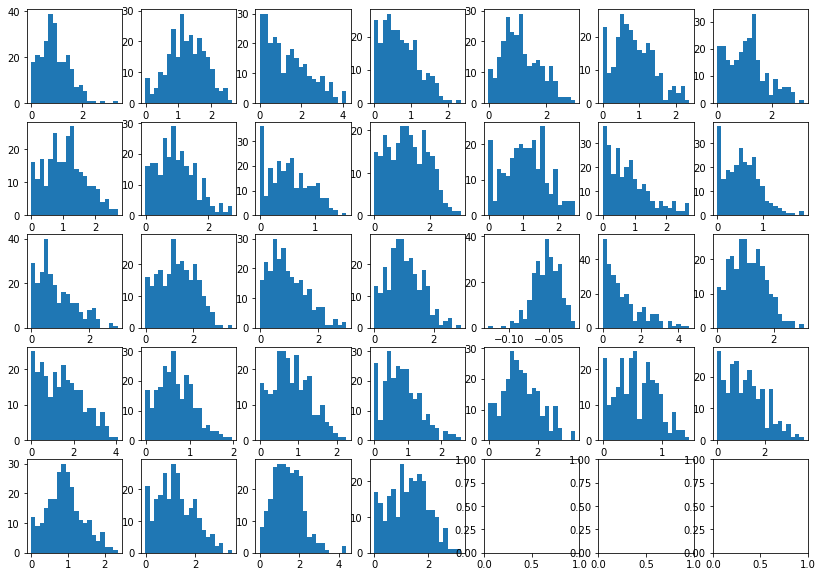

In [12]:
from plotting import plot_byvar_hist

plot_byvar_hist(encoded_test[:,:,0,0])

# Play around

- We are encoding digits in 32 numbers,  
  try encoding them in 16/64 values and check the difference.
- We are not using convolutions separated in depthwise + pointwise,  
  try using them and check the difference in #parameters and results.